In [1]:
import dataprocess as dp
import transformers
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ExponentialLR
from modelhelper import MSE_Vec_matrix
from modelhelper import Net
import torch
from torchvision import models


#TODO Normalize Xtest
#Make our own loss function

# Hyperparameters
# Batch Size, Num Epochs, Learning Rate, Momentum, FC Layer, Activation Function


# 0 Lowercase & N2W
# 1 Contractions
# 2 Remove Punctutations
# 3 Strop Words

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def accuracy(net, input_id, labels):
    j = len(labels)

    guesses = torch.argsort(net(input_id), dim=1, descending=True)
#     print("GUESS: ", guesses[:,0])

    # guess1 = torch.argmax(guesses, dim=1)
    # guess2 = torch.argsort(guesses, dim=1)[-2]


    # current_real = torch.tensor(labels)
    current_real = labels.clone().detach()
#     print("LABEL: ", current_real)

    top1_acc = torch.sum(current_real==guesses[:,0])
    top2_acc = torch.sum(current_real==guesses[:,1])


    # print(guesses[:100])
    # print(current_real[:100])
    # print("Guess: ", guesses, "Label: ", current_real)

    accuracy_1 = top1_acc / j
    accuracy_2 = (top2_acc + top1_acc) / j
    # print(running_acc)
    # print(j)

    # print('Accuracy for top 1: %d %%' % ((accuracy_1) * 100.0))
    # print('Accuracy for top 2: %d %%' % ((accuracy_2) * 100.0))

    return accuracy_1.item(), accuracy_2.item()

    

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aymane\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\Aymane\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aymane\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# !cd GitHub/EC523_Project/
# !pip install transformers

In [2]:
data = dp.unpickle_data("reviews_Electronics_5_7_encoded.pickle")

In [3]:
sentences = data['reviewText']
labels = data['overall']
print(sentences.shape)
print(len(labels))

torch.Size([1689188, 768])
1689188


In [4]:
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.1, random_state=42, stratify=labels)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

X_test = X_test.clone().detach()
y_test = torch.tensor(y_test).cuda()

for i in range(len(y_test)):
    y_test[i] = y_test[i] - 1 


# indecies = torch.permute(indecies)
# X_train = X_train[indexes,:]

X_train = X_train.clone().detach()
y_train = torch.tensor(y_train)

In [5]:
rev1 = X_train[y_train==1]
rev2 = X_train[y_train==2]
rev3 = X_train[y_train==3]
rev4 = X_train[y_train==4]
rev5 = X_train[y_train==5]

training_points = min(len(rev1), len(rev2), len(rev3), len(rev4), len(rev5))

rev1 = rev1 [:training_points]
rev2 = rev2 [:training_points]
rev3 = rev3 [:training_points]
rev4 = rev4 [:training_points]
rev5 = rev5 [:training_points]

indicies = torch.randperm(training_points * 5)

X_train = torch.cat((rev1, rev2, rev3, rev4, rev5), dim=0)[indicies, :]
base = torch.zeros(training_points)
y_train = torch.cat((base,base+1,base+2,base+3,base+4))[indicies]


The cell below handles all the MLP Variables

In [46]:
NUM_EPOCH = 10000
batch_size = 250

# Learning Rate Decay
LR_START  = 0.3
LR_END    = 1e-3
LR_GAMMA  = (LR_END/LR_START)**(1/NUM_EPOCH)

dropout = 0.15
hidden_layers = [[768, 200], [200, 70], [70, 20], [20, 5]]
activation_func = F.sigmoid

batch_norm = True

net = Net(  h_sizes=hidden_layers,
            dropout=dropout, 
            activation=activation_func,
            batch_norm=batch_norm).to(device)

print(net)

optimizer = torch.optim.SGD(net.parameters(), lr=LR_START, momentum=0.9)
criterion = torch.nn.MSELoss().to(device)
# criterion = torch.nn.CrossEntropyLoss().to(device)
scheduler = ExponentialLR(optimizer, gamma=LR_GAMMA)
MSE_vec   = MSE_Vec_matrix(mid=1)
MSE_vec.to(device)

Net(
  (linear): ModuleList(
    (0): Linear(in_features=768, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=70, bias=True)
    (2): Linear(in_features=70, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=5, bias=True)
  )
  (dropout): Dropout(p=0.15, inplace=False)
  (batch): ModuleList(
    (0): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (1): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  )
)


In [21]:
X_train = X_train.to(device)
y_train = y_train.long().to(device)
X_test  = X_test.to(device)

$$
\gamma = \left( \frac{\alpha}{\beta} \right)^{\frac{1}{e}}
$$

gamma is decay rate

beta is start learning rate

alpha is ending learning rate

e is number of epochs

In [47]:
train_losses = []
test_losses = []
accuracy1 = []
accuracy2 = []

In [48]:
indecies = torch.tensor(range(batch_size))

for epoch in range(NUM_EPOCH):
    running_loss = 0.0

    # Training mode
    net.train()
    for i in range(len(y_train)//batch_size):
    #for i in range(1):
        select = batch_size * i + indecies
        optimizer.zero_grad()
        outputs = net(X_train[select,:])

        # MSE Loss
        loss = criterion(outputs, MSE_vec[y_train[select]])

        # Cross Entropy Loss
        # loss = criterion(outputs, y_train[select])

        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()

    # Eval Mode
    net.eval()
    with torch.no_grad():

        # MSE
        training_loss = criterion(net(X_test),MSE_vec[y_test.long()]).item()

        # Cross Entropy
        # training_loss = criterion(net(X_test), y_test.long()).item()

        # Added .eval() to account for the added dropout layers
        ac1,ac2 = accuracy(net, X_test, y_test)
        accuracy1.append(ac1)
        accuracy2.append(ac2)
    
    print('[%d] loss: %.3f \t test loss: %.3f \t test_ac1: %.2f \t test_ac2: %.2f' %
    (epoch + 1, running_loss, training_loss*10,ac1,ac2))
    scheduler.step()
    
    train_losses.append(running_loss)
    test_losses.append(training_loss)
    running_loss = 0.0

[1] loss: 217.461 	 test loss: 1.651 	 test_ac1: 0.27 	 test_ac2: 0.43
[2] loss: 212.206 	 test loss: 1.493 	 test_ac1: 0.37 	 test_ac2: 0.54
[3] loss: 210.518 	 test loss: 1.447 	 test_ac1: 0.38 	 test_ac2: 0.58
[4] loss: 209.677 	 test loss: 1.542 	 test_ac1: 0.34 	 test_ac2: 0.52
[5] loss: 209.127 	 test loss: 1.448 	 test_ac1: 0.39 	 test_ac2: 0.58
[6] loss: 208.599 	 test loss: 1.513 	 test_ac1: 0.35 	 test_ac2: 0.54
[7] loss: 208.256 	 test loss: 1.403 	 test_ac1: 0.42 	 test_ac2: 0.61
[8] loss: 207.959 	 test loss: 1.478 	 test_ac1: 0.39 	 test_ac2: 0.56
[9] loss: 207.704 	 test loss: 1.416 	 test_ac1: 0.41 	 test_ac2: 0.60
[10] loss: 207.609 	 test loss: 1.422 	 test_ac1: 0.41 	 test_ac2: 0.60
[11] loss: 207.486 	 test loss: 1.500 	 test_ac1: 0.36 	 test_ac2: 0.54
[12] loss: 207.315 	 test loss: 1.488 	 test_ac1: 0.37 	 test_ac2: 0.56
[13] loss: 207.189 	 test loss: 1.444 	 test_ac1: 0.39 	 test_ac2: 0.59
[14] loss: 207.102 	 test loss: 1.474 	 test_ac1: 0.39 	 test_ac2: 0.56
[

Finished Training


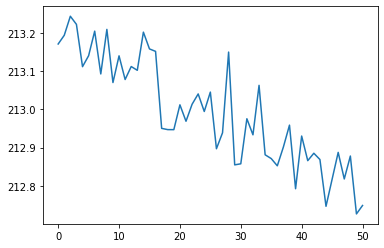

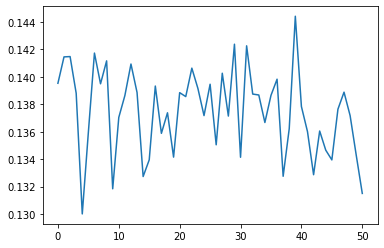

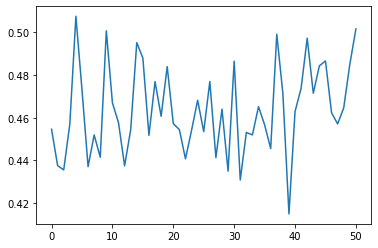

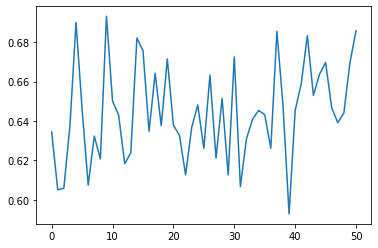

In [43]:
print('Finished Training')
plt.plot(train_losses)
plt.figure()
plt.plot(test_losses)
plt.figure()
plt.plot(accuracy1)
plt.figure()
plt.plot(accuracy2)

In [44]:
net = net.eval()

train_acc = accuracy(net, X_train.cuda(), y_train.cuda())
test_acc = accuracy(net, X_test, y_test)

print(train_acc)
print(test_acc)

(0.41968753933906555, 0.6957781910896301)
(0.5272143483161926, 0.7182774543762207)
